In [138]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [139]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=0.1, Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)

        # El valor del pasado
        self.rp = self.r
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m

        
        # Euler --> se calienta
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer --> se calienta
        #self.v += self.dt*self.a
        #self.r += self.dt*self.v

        #Leapfrog

        if i==0:
            self.r = self.rp + self.v*self.dt

        else:
            vhalf = self.V[i-1] + 0.5*self.dt*self.A[i-1]
        
            self.r = self.R[i-1] + self.dt*vhalf
        
            self.v = vhalf + 0.5*self.dt*self.a
        
        self.SetAcceleration(i)

        #Verlet --> se salta los muros
        #if i==0:
            #self.r = self.rp + self.v*self.dt
        #else:
            
            #rp pasado, r presente rf futuro
            #self.rf = 2*self.r - self.rp + self.a*self.dt**2
            #self.v = (self.rf - self.rp)/(2*self.dt)
            
            #self.rp = self.r
            #self.r = self.rf

        #Yoshida --> las bolas desaparecen
        #w0 = - ( 2.**(1./3.))/(2. - 2.**(1./3.))
        #w1 =  ( 1. )/( 2. - 2.**(1./3.))
        #c1 = w1/2.
        #c2 = (w0 + w1)/2.
        #c3 = c2
        #c4 = c1
        #d1 = w1
        #d2 = w0
        #d3 = d1

        #r1 = self.R[i-1] + c1*self.V[i-1]*self.dt
        #v1 = self.V[i-1] + d1*self.dt*self.a
        
        #r2 = r1 + c2*v1*self.dt
        #v2 = v1 + d2*self.dt*self.a
        
        #r3 = r2 + c3*v2*self.dt
        #v3 = v2 + d3*self.dt*self.a
        
        #self.r = r3 + c4*v3*self.dt
        #self.v = v3
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:

        
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r

    def SetAcceleration(self,i):
        self.A[i] = self.a
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(3):
            
            if self.r[i] + self.radius > 5 and self.v[i] > 0.:
                self.v[i] = -self.v[i]
                #while self.r[i] + self.radius > 5:
                    #self.r[i] += self.v[i]*self.dt
                    #self.rp[i] = self.r[i]
                
            elif self.r[i] - self.radius < -5 and self.v[i] < 0.:
                self.v[i] = -self.v[i]
                #while self.r[i] + self.radius < -5:
                    #self.r[i] += self.v[i]*self.dt
                    #self.rp[i] = self.r[i]
                

In [140]:
def GetParticles(N,t):
    
    part = np.linspace(0, N-1, N)
    Particles = []
    
    for i in part:
        r0 = np.random.uniform(low=-4.8, high=4.8, size=3)
        v0 = np.random.uniform(low=-5, high=5, size=3)
        a0 = np.zeros(3)
        p0 = Particle(r0, v0, a0, t, m=1, radius=0.1, Id=i)
        Particles.append(p0)
    
    return Particles

In [141]:
dt = 0.001
tmax = 15
t = np.arange(0,tmax,dt)
Particles = GetParticles(30,t)

# 20 segundos con 50 bolas se demora 15 minutos en simular 

In [142]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [143]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 15000/15000 [01:30<00:00, 164.98 Steps/s]


In [144]:
# Bajamos dimensión de la simulacion
scale = 50
t1 = t[::scale]

Particles[0].R

array([[ 0.05044782,  2.62379536, -3.77653659],
       [ 0.05169305,  2.62840124, -3.77424522],
       [ 0.05169305,  2.62840124, -3.77424522],
       ...,
       [ 0.41280817, -2.06038141, -3.6046842 ],
       [ 0.41280817, -2.06038141, -3.6046842 ],
       [ 0.41156294, -2.05577553, -3.60697556]])

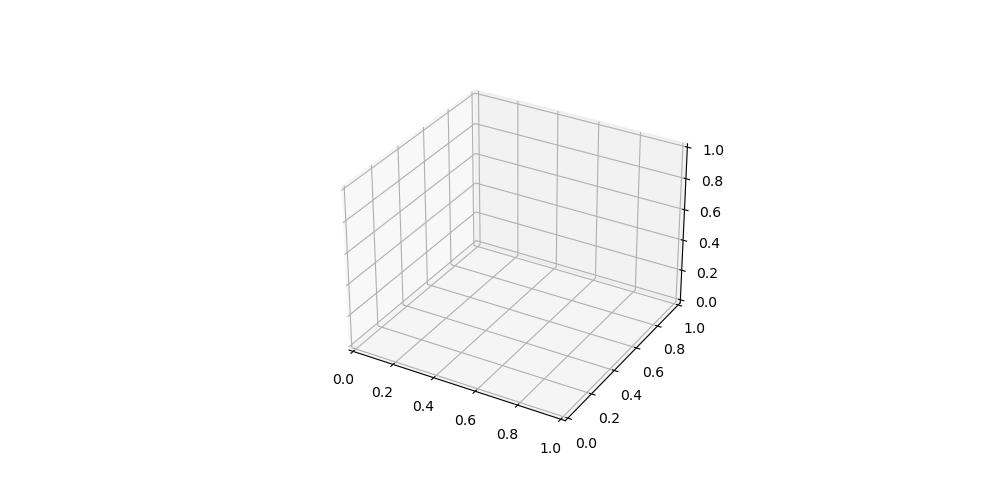

In [145]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
#ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_zlim3d(-5,5)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]
        
        #circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        #ax.add_patch(circle)
        ax.scatter(x,y,z)
        
        #ax.arrow(x,y,z,vx,vy,vz,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        #ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        #ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [146]:
KT = Particles[0].GetKineticEnergy(scale)

In [147]:
for i in range(1,len(Particles)):
    KT = np.add(KT,Particles[i].GetKineticEnergy(scale))

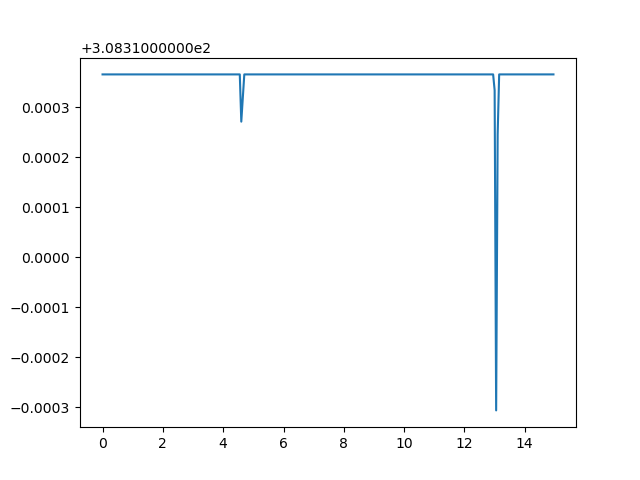

In [148]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(t1,KT)